# XGBoost

## Prerequisites
- Regression trees
- Gradient boosting

## Intro
XGBoost is a shorthand for eXtreme Gradient Boost. It is much like gradient boosting with decision trees. Similarly, it starts by making a single constant estimate for all examples and then uses a decision tree which predicts not the label, but the size and magnitude of the update that needs to be made to the previous estimate. The difference lies in the type of tree that it uses to make predictions. We discuss these below, before implementing XGBoost for regression.

## XGBoost trees

Each XGBoost tree starts with a single leaf which contains all of the residuals between the final predictions and their labels. We then calculate a **similarity score** for this leaf. This similarity score is like the mean squared error except that the quantity is squared once the individual errors have been added rather than before.
This means that negative and positive errors can cancel out to reduce the overall similarity.
The prediction made by the leaf is always the mean of the examples; so there will be feature values above and below the prediction (if more than a single example).
The equation also includes a regularisation parameter $\lambda$ added to the denominator. 
You can see this from the equation used to compute it below.

## Similarity $= \frac{(\Sigma^k x - y)^2}{k+\lambda}$
Where k is the number of examples which this tree makes predictions for.

**Note: we do not square the residuals before adding them up.** This means that residuals that are on opposite sides of the prediction cancel each other out, reducing the similarity score. 

The question is: would splitting the data classified by this tree produce a total similarity that is less than the current similarity.
To do this, we consider every possible split of this subset of datapoints (every midpoint between successive datapoints ordered along each axis). So we test each of these points by splitting the data at that feature's value to produce two leaves, then we again evaluate the similarity score for each of those leaves and add them together. The difference between the original similarity score and the sum of similarity scores over each leaf of one of these XGBoost trees is called the **gain**.

$Gain \ = \ similarity_{left} + similarity_{right} - similarity_{root}$

This gain is a heuristic indicating the best way to extend the tree.
Unlike other trees, it is not weighted by the number of examples that end up in each region.
It is also dependent on the similarity score of the parent leaf. 
Relative rather than absolute?

We evaluate the gain resulting from each of the potential splits. 
Then we extend the tree by adding the best split to the 

## How is this different to regular boosting? Why is it better?
This is the same procedure as boosting, except that the algorithm for extending the trees is different.
Instead of continuing to grow the tree by whichever split produces the least mean squared error (for regression), these XGBoost trees grow the tree by making branches that produces leaves with the greatest similarity score.

When the similarity score of new leaves is evaluated are made 

## What is the meaning of the similarity score?



Let's implement XGBoost from scratch.

(3, 1) (3, 1)
tree 0
similarity: 7.888609052210118e-31
similarity: 11.806630467520304
similarity: 11.806630467520309
gain: 23.613260935040614
similarity: 7.888609052210118e-31
similarity: 27.775678517380094
similarity: 27.775678517380104
gain: 55.5513570347602
best gain on this feature: 55.5513570347602
split val: 2.8263249678098425, gain: 55.5513570347602, split feature:0
best gain on this feature: 0
split val: None, gain: 0, split feature:None
similarity: 0.0
similarity: 0.6415144450325944
similarity: 0.6415144450325944
gain: 1.2830288900651887
best gain on this feature: 1.2830288900651887
split val: 0.1482178921382963, gain: 1.2830288900651887, split feature:0

tree 1
similarity: 0.0
similarity: 0.6415144450325944
similarity: 0.6415144450325944
gain: 1.2830288900651887
similarity: 0.0
similarity: 0.0
similarity: 0.0
gain: 0.0
best gain on this feature: 1.2830288900651887
split val: 0.1482178921382963, gain: 1.2830288900651887, split feature:0
similarity: 0.0
similarity: 0.1603786112

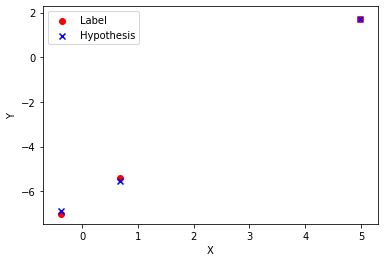

In [92]:
import sklearn.tree
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
import json
import copy
from utils import get_regression_data, visualise_regression_predictions
import numpy as np

# very similar to the regression tree that we implemented previously
class XGBoostTree:
    def __init__(self, max_depth=1):
        self.max_depth = max_depth

    def get_leaf_similarity_score(self, examples_in_region, prediction):
        """Return the similarity score for a leaf"""
        x, Y = examples_in_region
        # prediction = np.mean(Y)
        similarity = np.sum(Y - prediction)**2 # not mean squared error but squared mean error
        print('similarity:', similarity)
        return similarity

    def get_split_gain(self, x, Y, split_pos):
        """Get the gain for a given split"""
        parent_prediction = np.mean(Y)
        current_similarity = self.get_leaf_similarity_score((x, Y), parent_prediction)
        in_first_region = (x[x > split_pos], Y[x > split_pos])
        not_in_first_region = (x[x <= split_pos], Y[x <= split_pos])
        first_region_similarity = self.get_leaf_similarity_score(in_first_region, parent_prediction)
        not_in_first_region_similarity = self.get_leaf_similarity_score(not_in_first_region, parent_prediction)
        gain = first_region_similarity + not_in_first_region_similarity - current_similarity
        print('gain:', gain)
        return gain

    def get_split_candidates(self, x):
        """Get the values of a given feature to be tested as a potential place to split"""
        return (x[:-1] + x[1:]) / 2

    def get_best_split(self, X, Y):
        """Return the best feature and the best value to split the provided datapoints on"""
        best_feature_to_split_on = None
        best_gain = 0
        best_split_pos = None
        n_features = 1
        for feature_idx in range(n_features): # for each feature
            x = X[:, feature_idx] # get this feature from each example
            split_pos, split_gain = self.get_best_gain_on_this_feature(x, Y)
            print('best gain on this feature:', split_gain)
            if split_gain > best_gain:
                best_split_pos = split_pos
                best_gain = split_gain
                best_feature_to_split_on = feature_idx
        # print('best_split_gain:', best_gain)
        return best_split_pos, best_gain, best_feature_to_split_on

    def get_best_gain_on_this_feature(self, x, Y):
        """Get the best value to split the data on along this axis"""
        split_candidates = self.get_split_candidates(x)
        best_gain = 0
        best_split_pos = None
        for split_pos in split_candidates:
            gain = self.get_split_gain(x, Y, split_pos)
            if gain > best_gain:
                best_gain = gain
                best_split_pos = split_pos
        return best_split_pos, best_gain

    def extend_tree(self, X, Y, depth=0):
        """Recursively make branches of the tree"""
        split_val, split_gain, split_feature = self.get_best_split(X, Y)
        print(f'split val: {split_val}, gain: {split_gain}, split feature:{ split_feature}')
        if split_val == None: # split val will not exist (None) if there is only one datapoint in the split
            new_branch = {
                'split_gain': 0, # so the split is pure
                'prediction': np.mean(Y)
            }
            return new_branch
        
        positive_idxs = X[:, split_feature] > split_val
        positive_X = X[positive_idxs]
        positive_Y = Y[positive_idxs]
        negative_idxs = np.logical_not(positive_idxs)
        negative_X = X[negative_idxs]
        negative_Y = Y[negative_idxs]
        new_branch = {
            'split_gain': split_gain,
        }

        if depth < self.max_depth: # if not yet at max depth
            new_branch.update({
                'feature_to_split_on': split_feature,
                'value_to_split_on': split_val,
                'positive_branch': self.extend_tree(positive_X, positive_Y, depth=depth+1),
                'negative_branch': self.extend_tree(negative_X, negative_Y, depth=depth+1)
            })
        else:
            # print(len(Y))
            new_branch.update({'prediction': np.mean(Y)})
        return new_branch

    def fit(self, X, Y):
        """Fit the tree to the data"""
        self.tree = self.extend_tree(X, Y)

    def predict(self, X):
        """Return a prediction for a given input"""
        classifications = np.zeros(len(X))
        for idx, x in enumerate(X):
            tree = self.tree
            classified = False
            while classified == False:
                if 'prediction' in tree.keys(): # if the example can be classified from this branch (we have reached a leaf)
                    classified = True
                    classifications[idx] = tree['prediction']
                else: # if we need to ask further questions about the example to make splits
                    if x[tree['feature_to_split_on']] > tree['value_to_split_on']: # is the example1 in the positive branch
                        tree = tree['positive_branch'] # 
                    else: 
                        tree = tree['negative_branch']
        return classifications

    def __repr__(self):
        """Return the pretty printed string"""
        return json.dumps(self.tree, indent=4)

class XGBoost:
    def __init__(self, n_trees=10, learning_rate=0.1, tree_depth=1):
        self.n_trees = n_trees
        self.learning_rate = learning_rate
        self.tree_depth = tree_depth

    def predict(self, X):
        # prediction = np.zeros(len(X))
        for tree_idx, tree in enumerate(self.trees):
            if tree_idx == 0:
                prediction = tree.predict(X)
            else:
                # print(tree.predict(X))
                # scd
                prediction += self.learning_rate * tree.predict(X)
            print(prediction)
        print()
        return prediction

    def fit(self, X, Y):
        self.trees = []
        target = Y
        for tree_idx in range(self.n_trees):
            print(f'tree {tree_idx}')
            tree = XGBoostTree(max_depth=self.tree_depth)
            # print('x:', X)
            # print(X.shape)
            tree.fit(X, target)
            # print('target:', target)
            # print(target.shape)
            self.trees.append(tree)
            prediction = tree.predict(X).reshape(-1, 1)
            # print('prediction:', prediction)
            # print(prediction.shape)
            target = target - prediction
            # print('residual:', target)
            print()

X, Y = get_regression_data(m=3)
xgboost = XGBoost(n_trees=5, learning_rate=0.9, tree_depth=1)
xgboost.fit(X, Y)
predictions = xgboost.predict(X)
print(predictions)
visualise_regression_predictions(X, predictions, Y)
